### All-sky AME vs. IR Scatter Plots

In [1]:
%matplotlib inline
#from IPython.external import mathjax; mathjax.install_mathjax()
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import healpy.projector as pro
import astropy.io.fits as fits
from scipy.stats import gaussian_kde
import scipy
import pandas as pd
import pickle

In [21]:
## Force background color to be white:

plt.rcParams['axes.facecolor']='white'
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [3]:
with open('../Data/maps.pickle') as f:  # Python 3: open(..., 'rb')
    coords, planck_bb, planck_mw, phot, phot_modesub = pickle.load(f)
    
phot.head()
#planck_bb.head()
#planck_mw.head()
#coords.head()

,A9,D12,I12,W12,A18,D25,I25,D60,I60,A65,A90,D100,I100,D140,A140,A160,D240,P857,P545
0,NaN,1.083658,1.071264,0.018346,NaN,2.099690,2.142549,0.610734,0.598758,2.073384,1.688520,1.546775,1.529856,0.787866,2.403259,2.195928,0.991204,0.583666,0.258794
1,NaN,1.091430,1.045220,0.017045,NaN,2.119253,2.171547,0.690011,0.596552,1.928738,1.394335,1.506179,1.455086,3.546372,2.527890,2.874538,0.672390,0.620408,0.269439
2,NaN,1.093857,1.064194,0.012653,NaN,2.122237,2.159359,0.697645,0.596992,1.806098,1.456207,1.512805,1.544730,3.832097,2.485977,2.421713,0.951366,0.629106,0.272736
3,NaN,1.082492,1.066986,0.029448,NaN,2.092455,2.135687,0.612444,0.616380,2.072155,1.593516,1.554953,1.524600,0.697479,2.373043,2.408980,0.558173,0.612663,0.284378
4,NaN,1.086391,1.082960,0.003322,NaN,2.100158,2.150484,0.644721,0.611308,2.598172,1.715493,1.545120,1.503084,1.173915,2.235033,2.398738,1.534221,0.521117,0.238315


In [4]:
glatrange     = 10.0
glatrange_mid = 2.5
elatrange     = 10


gcut_l = np.where((abs(coords['glat']) < glatrange) & (abs(coords['elat']) > elatrange))
gcut_h = np.where((abs(coords['glat']) > glatrange) & (abs(coords['elat']) > elatrange))







In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler


### Setup the standard pipeline to apply to all the data:
allsky_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

phot_tr = pd.DataFrame(allsky_pipeline.fit_transform(phot),columns=phot.columns)
planck_bb_tr = pd.DataFrame(allsky_pipeline.fit_transform(planck_bb),columns=planck_bb.columns)
planck_mw_tr = pd.DataFrame(allsky_pipeline.fit_transform(planck_mw),columns=planck_mw.columns)


phot_corr = phot_tr.corr(method='spearman')
planck_bb_corr = planck_bb_tr.corr(method='spearman')
planck_mw_corr = planck_mw_tr.corr(method='spearman')


In [6]:
import seaborn as sb
phot_corr     = phot_tr.join(planck_mw_tr['AME']).corr(method='spearman')
phot_corr_lgl = phot_tr.join(planck_mw_tr['AME']).iloc[gcut_l].corr(method='spearman')
phot_corr_hgl = phot_tr.join(planck_mw_tr['AME']).iloc[gcut_h].corr(method='spearman')

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


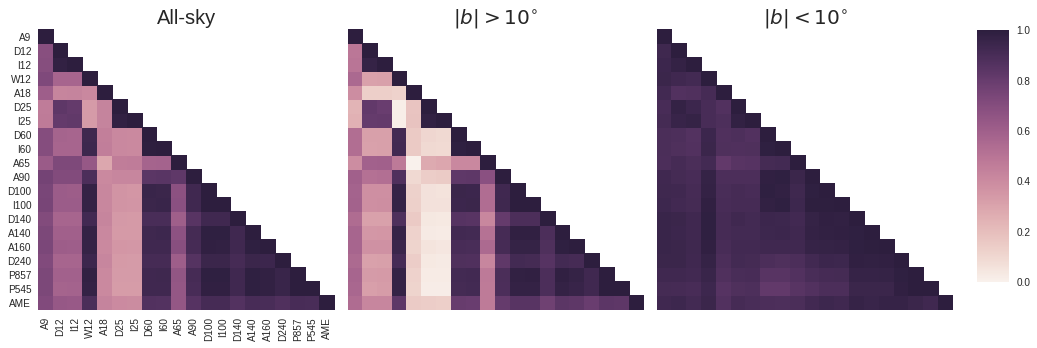

In [7]:
#bb_corr_drop = bb_corr.drop('AME',axis=0).drop('A9',axis=1)
mask = np.zeros_like(phot_corr.values)
mask[np.triu_indices_from(mask,k=1)] = True

with sb.axes_style("white"):

    
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    cbar_ax = fig.add_axes([.91, .2, .03, .7])
    
    sb.heatmap(
        phot_corr,
        #linewidths=.5,
        annot=False,
        mask=mask,
        cbar=False,
        yticklabels=True,
        xticklabels=True,
        ax = ax[0],
        vmin=0,
        vmax=1)
    
    ax[0].set_title("All-sky", fontsize=20)

    
    sb.heatmap(
        phot_corr_hgl,
        #linewidths=.5,
        annot=False,
        mask=mask,
        cbar=False,
        yticklabels=False,
        xticklabels=False,
        ax=ax[1],
        vmin=0,
        vmax=1)
    
    ax[1].set_title("$|b| > 10^{\circ}$", fontsize=20)

    
    
    sb.heatmap(
        phot_corr_lgl,
        #linewidths=.5,
        annot=False,
        mask=mask,
        cbar=True,
        cbar_ax=cbar_ax,
        yticklabels=False,
        xticklabels=False,
        ax=ax[2],
        vmin=0,
        vmax=1)
    
    ax[2].set_title("$|b| < 10^{\circ}$", fontsize=20)


    fig.tight_layout(rect=[0, 0, .9, 1])
    
    plt.show()

    fig.savefig("../Plots/all_bands_corr_matrix_wAME_spearman.pdf", bbox_inches='tight')

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


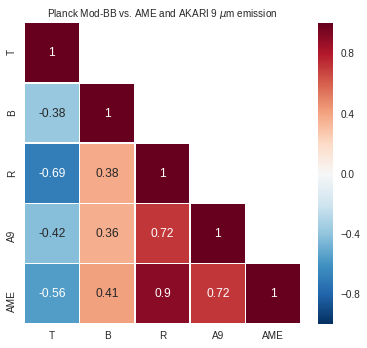

In [8]:
import seaborn as sb
planck_bb_corr = planck_bb_tr.join(phot_tr['A9']).join(planck_mw_tr['AME']).corr(method='spearman')
#bb_corr_drop = bb_corr.drop('AME',axis=0).drop('A9',axis=1)
mask = np.zeros_like(planck_bb_corr.values)
mask[np.triu_indices_from(mask,k=1)] = True



with sb.axes_style("white"):
    
    fig = plt.figure(figsize=(6,5))
    sb.heatmap(
        planck_bb_corr,
        linewidths=.5,
        annot=True,
        mask=mask)
    
    
    fig.show()
    
    plt.title("Planck Mod-BB vs. AME and AKARI 9 $\mu$m emission",fontsize=10)
    
    fig.tight_layout(rect=[0, 0, .9, 1])

    fig.savefig("../Plots/PlanckModBBvsAMEandA9.pdf", bbox_inches='tight')
    


# Correlation tests along Galactic meridians and parallels:

In [9]:
start = -90
stop = 90
step = 1

glat_intervs = np.arange(start,stop,step)

start = 0
stop = 360
step = 1

glon_intervs = np.arange(start,stop,step)

glats = [np.where(np.logical_and(coords['glat']>i, coords['glat']< i+1))  for i in glat_intervs]

glons = [np.where(np.logical_and(coords['glon']>i, coords['glon']< i+1))  for i in glon_intervs]

In [10]:
bba = planck_bb_tr.join(phot_tr['A9']).join(planck_mw_tr['AME'])

bb_corr_glats = [bba.iloc[i].corr(method='spearman') for i in glats]

bb_corr_glons = [bba.iloc[i].corr(method='spearman') for i in glons]

#bb_corr_glats_A9 = [bb_corr_glats[i]['A9']]

bb_corr_glats_pn = pd.Panel({i: bb_corr_glats[i] for i in glat_intervs})
bb_corr_glons_pn = pd.Panel({i: bb_corr_glons[i] for i in glon_intervs})

In [11]:
bba.columns

Index([u'T', u'B', u'R', u'A9', u'AME'], dtype='object')

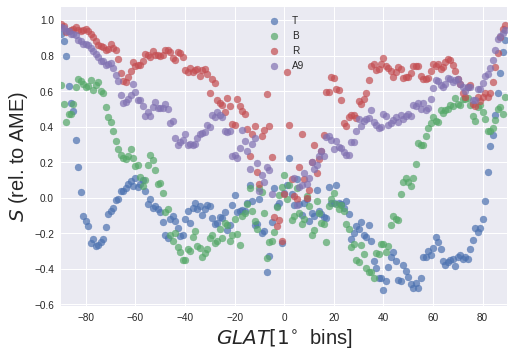

In [12]:
X = glat_intervs

Y = bb_corr_glats_pn.values[:,:,4]

fig, ax = plt.subplots()

for i in range(0,4):
    ax.scatter(X,Y[:,i], alpha=0.7, label=bba.columns[i])
    
legend = ax.legend(loc=0, shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')

plt.xlim(-90,90)
plt.ylabel("$S$ (rel. to AME)", fontsize=20)
plt.xlabel("$GLAT [1^{\circ}$  bins]", fontsize=20)
fig.show()

fig.savefig("../Plots/PlanckModBBvsAMEandA9_byGLAT.pdf", 
            bbox_inches ='tight')



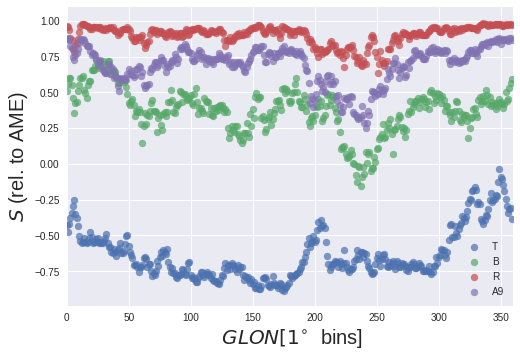

In [13]:
X = glon_intervs

Y = bb_corr_glons_pn.values[:,:,4]

fig, ax  = plt.subplots()

for i in range(0,4):
    ax.scatter(X,Y[:,i], alpha=0.7, label=bba.columns[i])
    
legend = ax.legend(loc=0, shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
#plt.legend(loc=1,prop={'size':14},fancybox=True, framealpha=1)
#leg.get_frame().set_alpha(0.5)
plt.xlim(0,360)
plt.ylabel("$S$ (rel. to AME)", fontsize=20)
plt.xlabel(" $GLON [1^{\circ}$  bins]", fontsize=20)
fig.show()

fig.savefig("../Plots/PlanckModBBvsAMEandA9_byGLON.pdf", 
            bbox_inches ='tight',
            facecolor = fig.get_facecolor())
#plt.close()
# plt.hist(bb_corr_glats_pn.dropna().values[:,2,0], bins=10, alpha=0.4, label='Beta')
# plt.hist(bb_corr_glats_pn.dropna().values[:,3,0], bins=10, alpha=0.4, label='FIR')
# plt.hist(bb_corr_glats_pn.dropna().values[:,4,0], bins=10, alpha=0.4, label='A9')



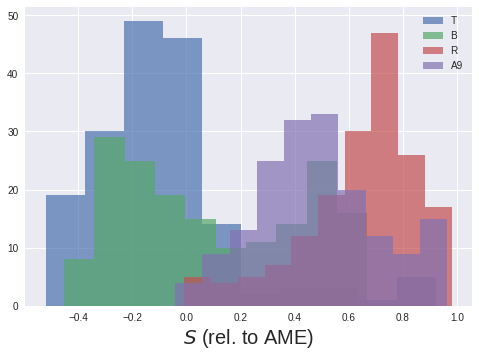

In [14]:
fig, ax = plt.subplots()

for i in range(0,4):
    ax.hist(bb_corr_glats_pn.dropna().values[:,i,4], alpha=0.7, label=bba.columns[i], bins=10)
ax.legend(loc=0)
plt.xlabel("$S$ (rel. to AME)", fontsize=20)
fig.show()

fig.savefig("../Plots/PlanckModBBvsAMEandA9_GLAT_hist.pdf", bbox_inches='tight')

#plt.plot[bb_corr_glats_pn.values[]])

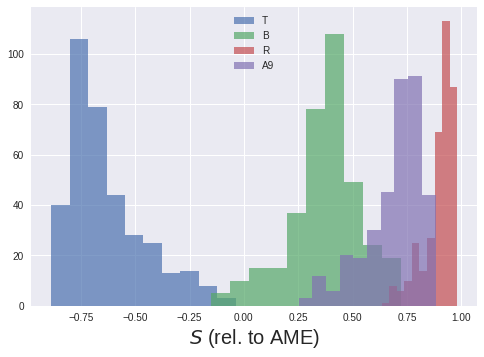

In [15]:
fig, ax = plt.subplots()

for i in range(0,4):
    ax.hist(bb_corr_glons_pn.dropna().values[:,i,4], alpha=0.7, label=bba.columns[i], bins=10)
ax.legend(loc=0)
plt.xlabel("$S$ (rel. to AME)", fontsize=20)
fig.show()

fig.savefig("../Plots/PlanckModBBvsAMEandA9_GLON_hist.pdf", bbox_inches='tight')

#plt.plot[bb_corr_glats_pn.values[]])

## AME to IR Ratio Averages:

In [34]:
(phot.values.T/planck_mw['AME'].values).T

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.


array([[        nan,  0.02752184,  0.02720705, ...,  0.02517376,
         0.01482346,  0.00657263],
       [        nan,  0.03237103,  0.0310005 , ...,  0.01994261,
         0.01840086,  0.00799137],
       [        nan,  0.03272788,  0.0318404 , ...,  0.02846459,
         0.01882269,  0.00816018],
       ..., 
       [        nan,  0.31129029,  0.29685713, ...,  0.69842934,
         0.19442235,  0.08502377],
       [        nan,  0.29789   ,  0.27756846, ...,  0.43214741,
         0.18432232,  0.07434121],
       [        nan,  0.07867091,  0.07640276, ...,  0.02196185,
         0.04742085,  0.01792569]])

In [37]:
phot_AME_ratio = pd.DataFrame(
    
    (phot.values.T/planck_mw['AME'].values).T,
    columns = phot.columns)
phot_AME_ratio.head()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


,A9,D12,I12,A18,D25,I25,D60,I60,A65,A90,D100,I100,D140,A140,A160,D240,P857,P545
0,NaN,0.027522,0.027207,NaN,0.053326,0.054415,0.015511,0.015207,0.052658,0.042884,0.039284,0.038854,0.020010,0.061036,0.055770,0.025174,0.014823,0.006573
1,NaN,0.032371,0.031001,NaN,0.062856,0.064407,0.020465,0.017693,0.057205,0.041355,0.044672,0.043157,0.105183,0.074975,0.085257,0.019943,0.018401,0.007991
2,NaN,0.032728,0.031840,NaN,0.063497,0.064607,0.020873,0.017862,0.054038,0.043569,0.045263,0.046218,0.114655,0.074380,0.072457,0.028465,0.018823,0.008160
3,NaN,0.030751,0.030311,NaN,0.059442,0.060670,0.017398,0.017510,0.058865,0.045268,0.044173,0.043310,0.019814,0.067413,0.068433,0.015856,0.017404,0.008079
4,NaN,0.027507,0.027420,NaN,0.053175,0.054449,0.016324,0.015478,0.065785,0.043436,0.039122,0.038058,0.029723,0.056590,0.060735,0.038846,0.013194,0.006034


In [50]:
phot_AME_ratio_glons = [phot_AME_ratio.iloc[i].dropna().mean() for i in glons]
np.shape(phot_AME_ratio_glons)
phot_AME_ratio_glons

[A9      inf
 D12     inf
 I12     inf
 A18     inf
 D25     inf
 I25     inf
 D60     inf
 I60     inf
 A65     inf
 A90     inf
 D100    inf
 I100    inf
 D140    NaN
 A140    inf
 A160    inf
 D240    inf
 P857    inf
 P545    inf
 dtype: float64, A9      inf
 D12     inf
 I12     inf
 A18     inf
 D25     inf
 I25     inf
 D60     inf
 I60     inf
 A65     inf
 A90     inf
 D100    inf
 I100    inf
 D140    NaN
 A140    inf
 A160    inf
 D240    inf
 P857    inf
 P545    inf
 dtype: float64, A9      inf
 D12     inf
 I12     inf
 A18     inf
 D25     inf
 I25     inf
 D60     inf
 I60     inf
 A65     inf
 A90     inf
 D100    inf
 I100    inf
 D140    inf
 A140    inf
 A160    inf
 D240    NaN
 P857    inf
 P545    inf
 dtype: float64, A9      inf
 D12     inf
 I12     inf
 A18     inf
 D25     inf
 I25     inf
 D60     inf
 I60     inf
 A65     inf
 A90     inf
 D100    inf
 I100    inf
 D140    inf
 A140    inf
 A160    inf
 D240    inf
 P857    inf
 P545    inf
 dtype: float64,

In [48]:

#IR_AME_ratios_glats = [phot.iloc[i]/pla) for i in glats]

phot_AME_ratio_glons = [phot_AME_ratio.iloc[i].dropna().mean() for i in glons]
phot_AME_ratio_glats = [phot_AME_ratio.iloc[i].dropna().mean() for i in glats]
#bb_corr_glats_A9 = [bb_corr_glats[i]['A9']]

phot_AME_ratio_glons_pn = pd.Panel({i: phot_AME_ratio_glons[i] for i in glon_intervs})
phot_AME_ratio_glats_pn = pd.Panel({i: phot_AME_ratio_glats[i] for i in glat_intervs})

IndexError: tuple index out of range

In [ ]:
phot_AME_ratio_glats

# All-sky AME vs. IR plots:

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


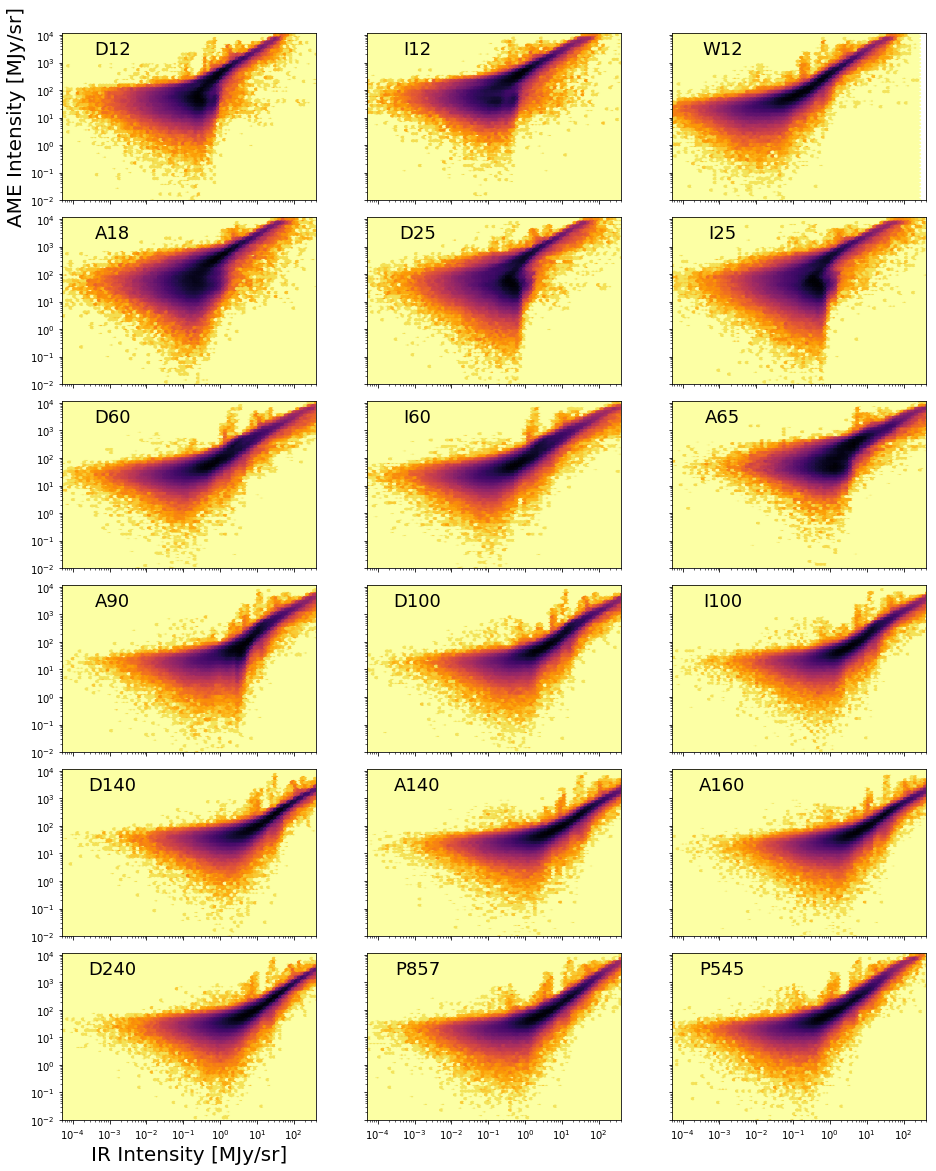

In [17]:
ncols=3
nrows=6

fig, axs = plt.subplots(ncols=ncols, 
                        nrows=nrows, 
                        sharey=True, 
                        sharex=True,
                       figsize=(20,20))
fig.subplots_adjust(hspace=0.1, left=0.1, right=0.7)

k=0


for i in range(0,nrows):
    for j in range(0,ncols):
        
            k += 1
            x = phot_modesub.values[:,k]

            y = planck_mw['AME'].values[:]
            
            x_ = x[(x>0) & (y>0)]
            y_ = y[(x>0) & (y>0)]
            
            
            xmin = 5e-5#x_.min()
            xmax = 400 #x_.max()
            ymin = 0.01#y_.min()
            ymax = y_.max()
            
            ax = axs[i,j]

            hb = ax.hexbin(x_, y_, 
                   mincnt=0,
                   gridsize=100,
                   bins='log', 
                   cmap='inferno_r',
                   xscale='log',
                   yscale='log')
            
            
            ax.axis([xmin, xmax, ymin, ymax])
            
            ax.text(0.2, 0.9,phot_modesub.columns[k], horizontalalignment='center',
              verticalalignment='center',
              transform=ax.transAxes, 
              fontsize=18)
            
            
ax = axs[0,0]
ax.set_ylabel('AME Intensity [MJy/sr]', fontsize=20)
ax = axs[-1,0]
ax.set_xlabel('IR Intensity [MJy/sr]', fontsize=20)

plt.show()

fig.savefig("../Plots/AMEvsDust_allsky_allbands.pdf", bbox_inches='tight')


In [9]:
phot_modesub.columns[k]

'D240'

# Angular Power Spectra:

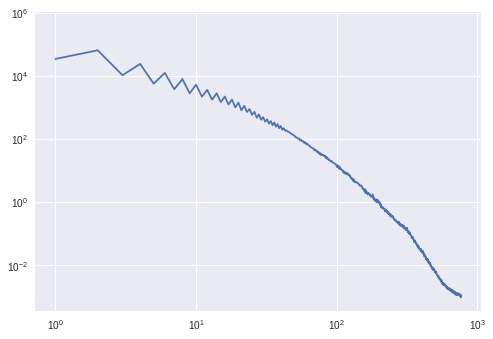

In [16]:
plt.loglog(hp.anafast(planck_mw['AME'].values))

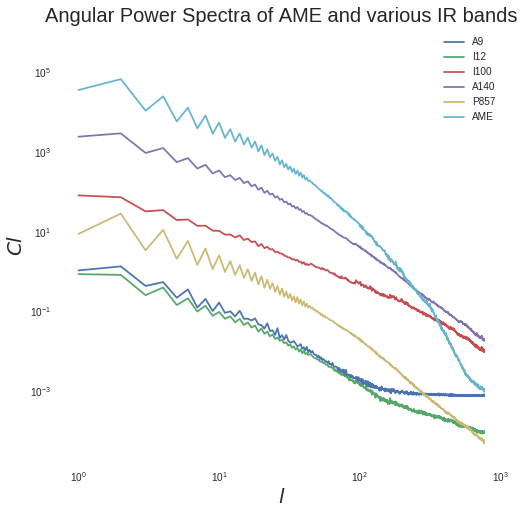

In [23]:
phot_unseens = phot.replace(
    to_replace =np.nan,
    value=hp.UNSEEN
    )

fig = plt.figure(figsize=(8,8))

plt.loglog(hp.anafast(phot_unseens['A9'].values), label="A9")
plt.loglog(hp.anafast(phot_unseens['I12'].values), label="I12")
plt.loglog(hp.anafast(phot_unseens['I60'].values), label="I100")
plt.loglog(hp.anafast(phot_unseens['A140'].values), label="A140")
plt.loglog(hp.anafast(phot_unseens['P545'].values), label="P857")

plt.loglog(hp.anafast(planck_mw['AME'].values), label="AME")

plt.title("Angular Power Spectra of AME and various IR bands", fontsize=20)
plt.xlabel("$l$", fontsize=20)
plt.ylabel("$Cl$",fontsize=20)




plt.legend()

fig.savefig("../Plots/AngPowerSpec_AMEandIR.pdf", bbox_inches='tight')

In [32]:
a140 = phot['A140'].replace(
    to_replace =np.nan,
    value=hp.UNSEEN
    ).values

hp.anafast(a140)

array([  1.34295546e+04,   2.36852716e+03,   2.86843921e+03,
         9.28437002e+02,   1.22954449e+03,   5.45323615e+02,
         6.87868772e+02,   3.77940367e+02,   4.67558303e+02,
         2.85590888e+02,   3.36646576e+02,   2.29587003e+02,
         2.56847434e+02,   1.94405300e+02,   2.20598351e+02,
         1.62970501e+02,   1.79729490e+02,   1.36165525e+02,
         1.50191931e+02,   1.10977386e+02,   1.25585424e+02,
         9.28267601e+01,   1.05150083e+02,   8.39246749e+01,
         8.86250653e+01,   7.09369327e+01,   7.60343472e+01,
         6.22373849e+01,   6.56794883e+01,   5.41353806e+01,
         5.62358482e+01,   4.80324987e+01,   4.98327408e+01,
         4.23036536e+01,   4.38575593e+01,   3.80477998e+01,
         4.11283366e+01,   3.46954951e+01,   3.63917650e+01,
         3.09337403e+01,   3.26753157e+01,   2.79574992e+01,
         2.89280217e+01,   2.60015087e+01,   2.61910818e+01,
         2.50652018e+01,   2.40816889e+01,   2.23372023e+01,
         2.14298394e+01,